In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Paths to the main dataset and the splits
train_dir = '/content/drive/MyDrive/Dataset/Train'
test_dir = '/content/drive/MyDrive/Dataset/Test'

In [ ]:
# Image data generators for training and test
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # ResNet50v2 input size
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation
)


Found 5450 images belonging to 10 classes.
Found 1367 images belonging to 10 classes.


In [ ]:
# Load the ResNet50v2 model with pre-trained weights, excluding the top layers
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a new model with additional layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 classes
])


In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    training_set,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
170/170 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.8068

170/170 [==============================] - 1326s 8s/step - loss: 0.6083 - accuracy: 0.8068
Epoch 2/10
170/170 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9607

170/170 [==============================] - 84s 494ms/step - loss: 0.1489 - accuracy: 0.9607
Epoch 3/10
170/170 [==============================] - ETA: 0s - loss: 0.0911 - accuracy: 0.9766

170/170 [==============================] - 85s 499ms/step - loss: 0.0911 - accuracy: 0.9766
Epoch 4/10
170/170 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9856

170/170 [==============================] - 83s 490ms/step - loss: 0.0653 - accuracy: 0.9856
Epoch 5/10
170/170 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9900

170/170 [==============================] - 82s 484ms/step - loss: 0.0464 - accuracy: 0.9900
Epoch 6/10
170/170 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9906

170/170 [==============================] - 83s 488ms/step - loss: 0.0422 - accuracy: 0.9906
Epoch 7/10
170/170 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9922

170/170 [==============================] - 84s 491ms/step - loss: 0.0344 - accuracy: 0.9922
Epoch 8/10
170/170 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9954

170/170 [==============================] - 84s 495ms/step - loss: 0.0261 - accuracy: 0.9954
Epoch 9/10
170/170 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9963

170/170 [==============================] - 82s 481ms/step - loss: 0.0210 - accuracy: 0.9963
Epoch 10/10
170/170 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9954

170/170 [==============================] - 83s 488ms/step - loss: 0.0216 - accuracy: 0.9954


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set, steps=test_set.samples // test_set.batch_size)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

42/42 [==============================] - 358s 9s/step - loss: 0.0483 - accuracy: 0.9874
Validation Loss: 0.0483
Validation Accuracy: 0.9874


In [ ]:
model.save('/content/drive/MyDrive/Dataset/ResNet50V2.h5')
print("Model saved to disk.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to disk.


In [ ]:
# Predict on the test set
Y_pred = model.predict(test_set, steps=test_set.samples // test_set.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

43/43 [==============================] - 12s 274ms/step


In [ ]:
y_true = test_set.classes

In [ ]:
print('Classification Report')
target_names = list(test_set.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

    Chhattisgarh       1.00      1.00      1.00       129
         Gujarat       0.99      1.00      0.99       179
         Haryana       0.99      1.00      1.00       128
Himachal Pradesh       0.98      0.96      0.97       128
      Karanataka       1.00      0.99      1.00       129
          Kerala       0.99      0.96      0.98       138
     Maharashtra       0.98      0.99      0.98       150
         Manipur       1.00      1.00      1.00       129
         Mizoram       0.98      0.98      0.98       129
     West Bengal       0.96      0.98      0.97       128

        accuracy                           0.99      1367
       macro avg       0.99      0.99      0.99      1367
    weighted avg       0.99      0.99      0.99      1367



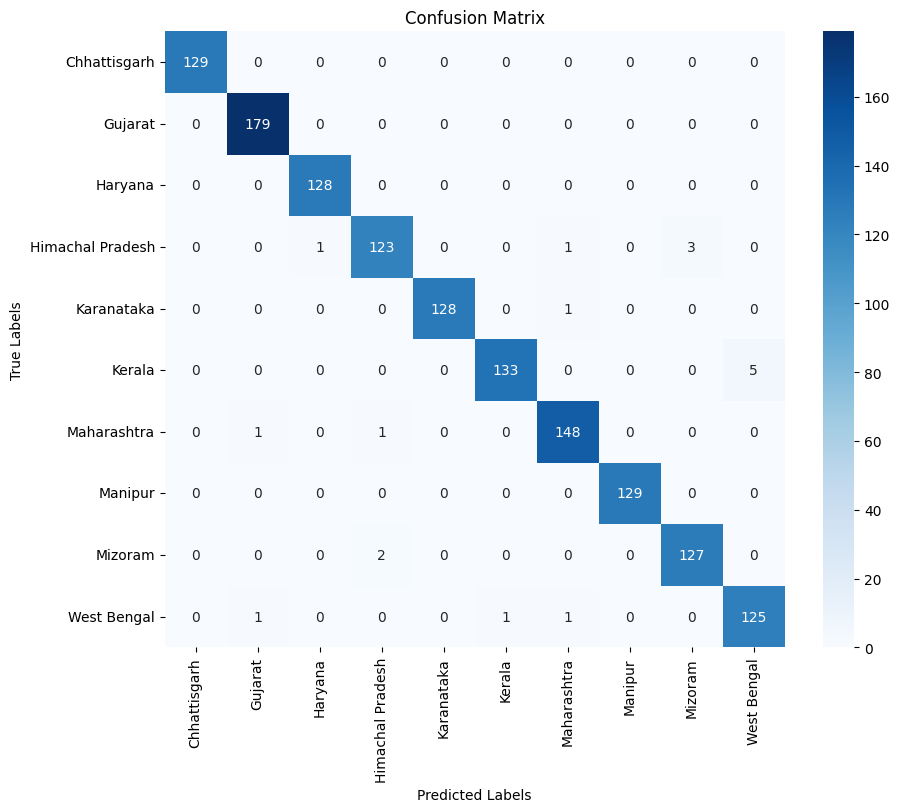

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

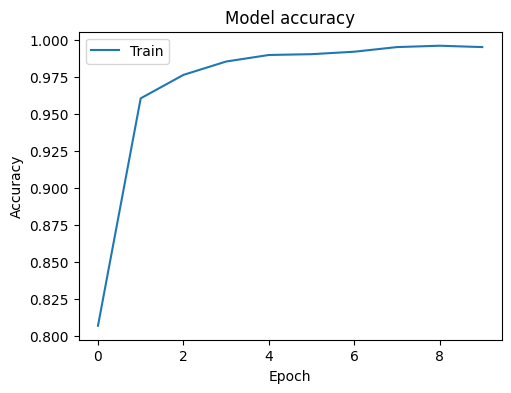

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

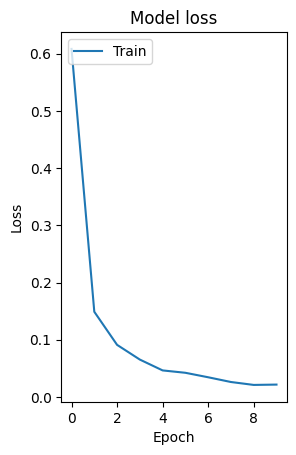

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [10]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/ResNet50V2.h5')

# Define the preprocessing function
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch axis
    img_array /= 255.0  # Normalize to [0,1]
    return img_array

# Load and preprocess the image
img_path = '/content/drive/MyDrive/Dataset/Test11/C_4_9_11zon.jpg'
img_array = preprocess_image(img_path)

# Predict the spice
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Manually define class indices
class_indices = {
    0: 'Chhattisgarh',
    1: 'Gujarat',
    2: 'Haryana',
    3: 'Himachal Pradesh',
    4: 'Karanataka',
    5: 'Kerala',
    6: 'Maharashtra',
    7: 'Manipur',
    8: 'Mizoram',
    9: 'West Bengal'
    # Add other classes here in the correct order
}

# Map the predicted class index to the spice name
predicted_state = class_indices[predicted_class]

print(f'The predicted state is: {predicted_state}')

1/1 [==============================] - 1s 1s/step
The predicted state is: Chhattisgarh


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2

# Load your trained model or pretrained model
# Assuming you have trained your ResNet50V2 model for spice classification
model =ResNet50V2(weights='imagenet')  # Replace with your actual trained model
test_score = [0.0, 0.98]  # Replace with your actual test scores

# Compile the model to avoid warning about compiled metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define model name directly
model_name = 'ResNet50V2'
subject = 'State Wise Costume Image Classification'
acc = test_score[1] * 100  # Assuming test_score[1] is the accuracy
save_path = '/content/drive/MyDrive/Dataset'  # Specify your desired save path

# Create the filename for saving the model
save_id = f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.keras'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Create the filename for saving the weights
weight_save_id = f'{model_name}-{subject}-weights.keras'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as /content/drive/MyDrive/Dataset/ResNet50V2-State Wise Costume Image Classification-98.00.keras
weights were saved as /content/drive/MyDrive/Dataset/ResNet50V2-State Wise Costume Image Classification-weights.keras
